Alzheimer's disease calssification on ADNI dataset
=============

we build a convolutional neural network to train a model to calssify the alzhimer desease from ADNI dataset.


In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
import numpy as np

import os, sys
import numpy as np
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib

import tensorflow as tf

In [2]:
pickle_file = 'pck1.pickle'
with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset_all = save['train_dataset']
  train_labels_all = save['train_labels']
  valid_dataset_all = save['valid_dataset']
  valid_labels_all = save['valid_labels']
  test_dataset_all = save['test_dataset']
  test_labels_all = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset_all.shape, train_labels_all.shape)
  print('Validation set', valid_dataset_all.shape, valid_labels_all.shape)
  print('Test set', test_dataset_all.shape, test_labels_all.shape)

Training set (105, 62, 96, 96) (105,)
Validation set (22, 62, 96, 96) (22,)
Test set (23, 62, 96, 96) (23,)


In [3]:
for n in range(19):
    pickle_file = 'pck%d.pickle' % (n+1)
    with open(pickle_file, 'rb') as f:
      save = pickle.load(f)
      train_dataset_all = np.vstack((train_dataset_all,save['train_dataset']))
      train_labels_all = np.hstack((train_labels_all,save['train_labels']))
      valid_dataset_all = np.vstack((valid_dataset_all,save['valid_dataset']))
      valid_labels_all = np.hstack((valid_labels_all,save['valid_labels']))
      test_dataset_all = np.vstack((test_dataset_all,save['test_dataset']))
      test_labels_all = np.hstack((test_labels_all,save['test_labels']))
      del save  # hint to help gc free up memory
print('Training set', train_dataset_all.shape, train_labels_all.shape)
print('Validation set', valid_dataset_all.shape, valid_labels_all.shape)
print('Test set', test_dataset_all.shape, test_labels_all.shape)

Training set (2109, 62, 96, 96) (2109,)
Validation set (436, 62, 96, 96) (436,)
Test set (469, 62, 96, 96) (469,)


In [6]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
  
train_dataset, train_labels = randomize(train_dataset, train_labels_all)
test_dataset, test_labels = randomize(test_dataset, test_labels_all)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels_all)
        
print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Valid set', valid_dataset.shape, valid_labels.shape)

Training set (2109, 1, 96, 96) (2109,)
Test set (469, 1, 96, 96) (469,)
Valid set (436, 1, 96, 96) (436,)


In [7]:
num_labels = 3
num_channels = 1 # grayscale

trY_all = []
for n in train_labels:
    for i in range(slcNum):
        trY_all.append(n)
train_labels = np.asarray(trY_all)

teY_all = []
for n in test_labels:
    for i in range(slcNum):
        teY_all.append(n)
test_labels = np.asarray(teY_all)

vaY_all = []
for n in valid_labels:
    for i in range(slcNum):
        vaY_all.append(n)
valid_labels = np.asarray(vaY_all)

def reformat(dataset, labels):
  dataset = dataset.reshape((dataset.shape[0]*dataset.shape[1],dataset.shape[2],dataset.shape[3]))  
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(1, num_labels+1) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels  = reformat(train_dataset, train_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Valid set', valid_dataset.shape, valid_labels.shape)

Training set (2109, 96, 96, 1) (2109, 3)
Test set (469, 96, 96, 1) (469, 3)
Valid set (436, 96, 96, 1) (436, 3)


In [8]:
meanVal = np.mean(train_dataset)
train_dataset -= meanVal
test_dataset -= meanVal
valid_dataset -= meanVal

In [9]:
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)
print('Valid set', valid_dataset.shape, valid_labels.shape)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) / predictions.shape[0])

Training set (2109, 96, 96, 1) (2109, 3)
Test set (469, 96, 96, 1) (469, 3)
Valid set (436, 96, 96, 1) (436, 3)


In [10]:
def checkDist(labels):
  nCnt, MCICnt, ADCnt = 0, 0, 0  
  for i in xrange(labels.shape[0]):
        if np.argmax(labels[i]) == 0 :
            nCnt += 1
        elif np.argmax(labels[i]) == 1 :
            MCICnt += 1
        elif np.argmax(labels[i]) == 2 :
            ADCnt += 1
  return nCnt, MCICnt, ADCnt
  
trNl, trMCIl, trADl = checkDist(train_labels)
teNl, teMCIl, teADl = checkDist(test_labels)
vaNl, vaMCIl, vaADl = checkDist(valid_labels)


print('ADNI distribution percentage in train dataset (Normal, MCI, AD):%.2f%% vs. %.2f%% vs. %.2f%%' % \
      (trNl*100./train_labels.shape[0], trMCIl*100./train_labels.shape[0], trADl*100./train_labels.shape[0]))
print('ADNI distribution percentage in test dataset  (Normal, MCI, AD):%.2f%% vs. %.2f%% vs. %.2f%%' % \
      (teNl*100./test_labels.shape[0], teMCIl*100./test_labels.shape[0], teADl*100./test_labels.shape[0]))
print('ADNI distribution percentage in valid dataset (Normal, MCI, AD):%.2f%% vs. %.2f%% vs. %.2f%%' % \
      (vaNl*100./valid_labels.shape[0], vaMCIl*100./valid_labels.shape[0], vaADl*100./valid_labels.shape[0]))

ADNI distribution percentage in train dataset (Normal, MCI, AD):45.52% vs. 23.66% vs. 30.82%
ADNI distribution percentage in test dataset (Normal, MCI, AD):31.34% vs. 34.54% vs. 34.12%
ADNI distribution percentage in valid dataset (Normal, MCI, AD):28.67% vs. 38.99% vs. 32.34%


In [11]:
net_data = np.load("bvlc_alexnet.npy").item()
batch_size = 64
num_channels = 1
image_size = 96
numHidden = 1024

# Alexnet convolution layer.
def conv(input, kernel, biases, k_h, k_w, c_o, s_h, s_w,  padding="VALID", group=1):

    c_i = input.get_shape()[-1]
    assert c_i%group==0
    assert c_o%group==0
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)
    

    if group==1:
        conv = convolve(input, kernel)
    else:
        input_groups = tf.split(3, group, input)
        kernel_groups = tf.split(3, group, kernel)
        output_groups = [convolve(i, k) for i,k in zip(input_groups, kernel_groups)]
        conv = tf.concat(3, output_groups)
    return  tf.reshape(tf.nn.bias_add(conv, biases), [-1]+conv.get_shape().as_list()[1:])
    
# Model.
def model(data, layers, is_training, keepProb):
    
    #x = tf.image.resize_images(data, [227, 227])
    net = data
    netGraph = {}
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            [kernels, bias] = net_data[name]
            if name == 'conv1':
                kernels = (kernels[:,:,0:1,:] + 
                         kernels[:,:,1:2,:] + 
                         kernels[:,:,2:,:])/3.
            with tf.variable_scope(name):
                w = tf.get_variable("W", shape=kernels.shape, initializer=tf.constant_initializer(kernels))
                b = tf.get_variable("b", shape=bias.shape, initializer=tf.constant_initializer(bias))
            if name[-1] == '1' :
                #conv1       
                #conv(11, 11, 96, 4, 4, padding='VALID', name='conv1')
                k_h = 11; k_w = 11; c_o = 96; s_h = 2; s_w = 2; group = 1   
            elif name[-1] == '2' :
                #conv2
                #conv(5, 5, 256, 1, 1, group=2, name='conv2')
                k_h = 5; k_w = 5; c_o = 256; s_h = 1; s_w = 1; group = 2
            elif name[-1] == '3' :
                #conv3
                #conv(3, 3, 384, 1, 1, name='conv3')
                k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 1
            elif name[-1] == '4' :
                #conv4
                #conv(3, 3, 384, 1, 1, group=2, name='conv4')
                k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 2
            elif name[-1] == '5' :
                #conv5
                #conv(3, 3, 256, 1, 1, group=2, name='conv5')
                k_h = 3; k_w = 3; c_o = 256; s_h = 1; s_w = 1; group = 2 
            net = conv(net, w, b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)    
            net = tf.contrib.layers.batch_norm(net, is_training=is_training, 
                                                 center=True, scale=True, scope=name,
                                               activation_fn=tf.nn.relu, updates_collections=None)
                
        elif kind[:3] == 'max':
            net = tf.nn.max_pool(net, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='VALID')
        elif kind == 'drop':
            net = tf.nn.dropout(net, keepProb)
        elif kind == 'fcl1':
            with tf.variable_scope(name, reuse=None):
                w = tf.get_variable("W", shape=[5*5*256, numHidden], initializer=tf.random_normal_initializer(0, 0.1))
                b = tf.get_variable("b", shape=[numHidden], initializer=tf.constant_initializer(1))
            net = tf.reshape(net, [-1, int(np.prod(net.get_shape()[1:]))])
            net = tf.nn.relu_layer(net, w, b)
        elif kind == 'fcl2':
            with tf.variable_scope(name, reuse=None):
                w = tf.get_variable("W", shape=[numHidden, numHidden], initializer=tf.random_normal_initializer(0, 0.1))
                b = tf.get_variable("b", shape=[numHidden], initializer=tf.constant_initializer(1))
            net = tf.nn.relu_layer(net, w, b)
        elif kind == 'fcl3':
            with tf.variable_scope(name, reuse=None):
                w = tf.get_variable("W", shape=[numHidden, num_labels], initializer=tf.random_normal_initializer(0, 0.1))
                b = tf.get_variable("b", shape=[num_labels], initializer=tf.constant_initializer(0))
            net = tf.nn.xw_plus_b(net, w, b)
            
        netGraph[name] = net

    return netGraph

In [30]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    inputX = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
    inputY  = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    dropPar  = tf.placeholder(tf.float32)
    reguPar  = tf.placeholder(tf.float32)
    phase = tf.placeholder(tf.bool, name='phase')
    
    layers = (
        'conv1', 'max1', 
        'conv2', 'max2', 
        'conv3', 'conv4', 
        'conv5', 'max5',
        'fcl1', 'dropFc1',
        'fcl2', 'dropFc2',
        'fcl3'
    )    

    
    # Training computation., name="conv1W"
    netOuts = model(inputX, layers, phase, dropPar)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(netOuts['fcl3'], inputY))
    ws   = tf.trainable_variables() 
    actLayersList = ws[8:]
    lossL2 = tf.add_n([tf.nn.l2_loss(w) for w in ws[8:]])*reguPar  
    loss = tf.reduce_mean(loss + lossL2)
    
    # Optimizer.
    global_step = tf.Variable(0)  # count the number of steps taken.
    #learning_rate = tf.train.exponential_decay(0.01, global_step, 10000, 0.97)
    learning_rate = tf.train.exponential_decay(8e-5, global_step, 300, 0.95)
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step, var_list=actLayersList)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step, var_list=actLayersList)
    #optimizer = tf.train.MomentumOptimizer(learning_rate, 0.95 ).minimize(loss, global_step=global_step, var_list=actLayersList)
    #optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)

    # Predictions for the training, validation, and test data.
    train_prediction =  tf.nn.softmax(netOuts['fcl3'])
    valid_prediction = tf.nn.softmax(netOuts['fcl3'])
    test_prediction = tf.nn.softmax(netOuts['fcl3'])  # Save the variables to disk.
    test_features = netOuts['fcl2']  # Save the variables to disk.
    saver = tf.train.Saver()  

In [31]:
numEp = 4
numItperEp = train_dataset.shape[0] // batch_size + 1
print('number of iteration per epoche: %d'% numItperEp)

num_steps = numItperEp * numEp
newAccval = 0.
ts = time.time()
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')  
    saver.restore(session, "tfClAlexnetGray.ckpt")
    print("Model restored.")        
    reguNum = 1e-10  
    dropNum = 0.9
    for epoch in range(numEp): 
        try:     
            if epoch > 80 :
                dropNum -= 0.05
                reguNum /= 2
            else :
                dropNum = 0.9
            avg_loss = 0.
            avg_acc = 0
            # Loop over all batches
            for i in range(numItperEp): 
                randidx  = np.random.randint(train_dataset.shape[0], size=batch_size)
                batch_data = train_dataset[randidx, :, :, :]
                batch_labels = train_labels[randidx, :]  
                feed_dict = {inputX : batch_data, inputY : batch_labels,
                            dropPar : dropNum, reguPar : reguNum, phase : True}
                # Fit training using batch data
                _, l = session.run([optimizer, loss], feed_dict=feed_dict)
                # Compute average loss
                avg_loss += l  
                feed_dict = {inputX : batch_data, dropPar : 1., reguPar : 0., phase : False}
                predictions = session.run(train_prediction, feed_dict=feed_dict)
                avg_acc += accuracy(predictions, batch_labels)
                #if (i % 50 == 0):
            print('epoch/numEp %02d/%02d: | loss: %.4f | accuracy: %.1f%% | time: %.1f (min)' % 
                  (epoch, numEp, avg_loss/(i+1), (avg_acc/(i+1)), (time.time() - ts)/60))
            if (epoch % 1 == 0):
                oldAccval = newAccval   
                num_batch = int(valid_labels.shape[0]/batch_size)
                avgAcc = 0
                for i in range(num_batch): 
                    offset  = i * batch_size
                    batch_data = valid_dataset[offset:(offset+batch_size), :, :, :]
                    feed_dict = {inputX : batch_data, dropPar : 1., reguPar : 0., phase : False}
                    validPredictions = valid_prediction.eval(feed_dict = feed_dict)
                    avgAcc += accuracy(validPredictions, valid_labels[offset:(offset+batch_size), :])            
                newAccval =  avgAcc / num_batch
                print('Validation accuracy: %.1f%%' % newAccval)
                if newAccval-oldAccval < 0.0 and epoch > 50:
                    break
        except KeyboardInterrupt:
            print("interrupted by user")
            break                    
    # Save the variables to disk.
    save_path = saver.save(session, "tfClAlexnetGray.ckpt")
    print("Model saved in file: %s" % save_path)
    
    num_batch = int(test_labels.shape[0]/batch_size)
    avgAcc = 0
    testPredictions = []
    features = []
    features_labels = []   
    for i in range(num_batch): 
        offset  = i * batch_size
        batch_data = test_dataset[offset:(offset+batch_size), :, :, :]
        features_labels.append(train_labels[offset:(offset+batch_size), :])   
        feed_dict = {inputX : batch_data, dropPar : 1., reguPar : 0., phase : False}
        features.append(session.run(test_features, feed_dict=feed_dict))   
        testPredictions.append(test_prediction.eval(feed_dict = feed_dict))
        avgAcc += accuracy(testPredictions[i], test_labels[offset:(offset+batch_size), :])
    features = np.asarray(features)
    features_labels = np.asarray(features_labels)
    testPredictions = np.asarray(testPredictions)
    testPredictions = np.reshape(testPredictions, (testPredictions.shape[0]*testPredictions.shape[1], testPredictions.shape[2]))   
    outFC2 = np.reshape(features, (features.shape[0]*features.shape[1], features.shape[2]))   
    features_labels = np.reshape(features_labels, (features_labels.shape[0]*features_labels.shape[1], features_labels.shape[2]))   
    print (" Test accuracy: %.3f" % (avgAcc / num_batch))        


number of iteration per epoche: 33
Initialized
Model restored.
epoch/numEp 00/04: | loss: 0.0389 | accuracy: 98.4% | time: 1.7 (min)
Validation accuracy: 74.2%
epoch/numEp 01/04: | loss: 0.0409 | accuracy: 98.8% | time: 3.5 (min)
Validation accuracy: 74.2%
epoch/numEp 02/04: | loss: 0.0361 | accuracy: 98.9% | time: 5.4 (min)
Validation accuracy: 74.2%
epoch/numEp 03/04: | loss: 0.0397 | accuracy: 98.8% | time: 7.2 (min)
Validation accuracy: 74.2%
Model saved in file: tfClAlexnetGray.ckpt
 Test accuracy: 81.250


(448, 3)


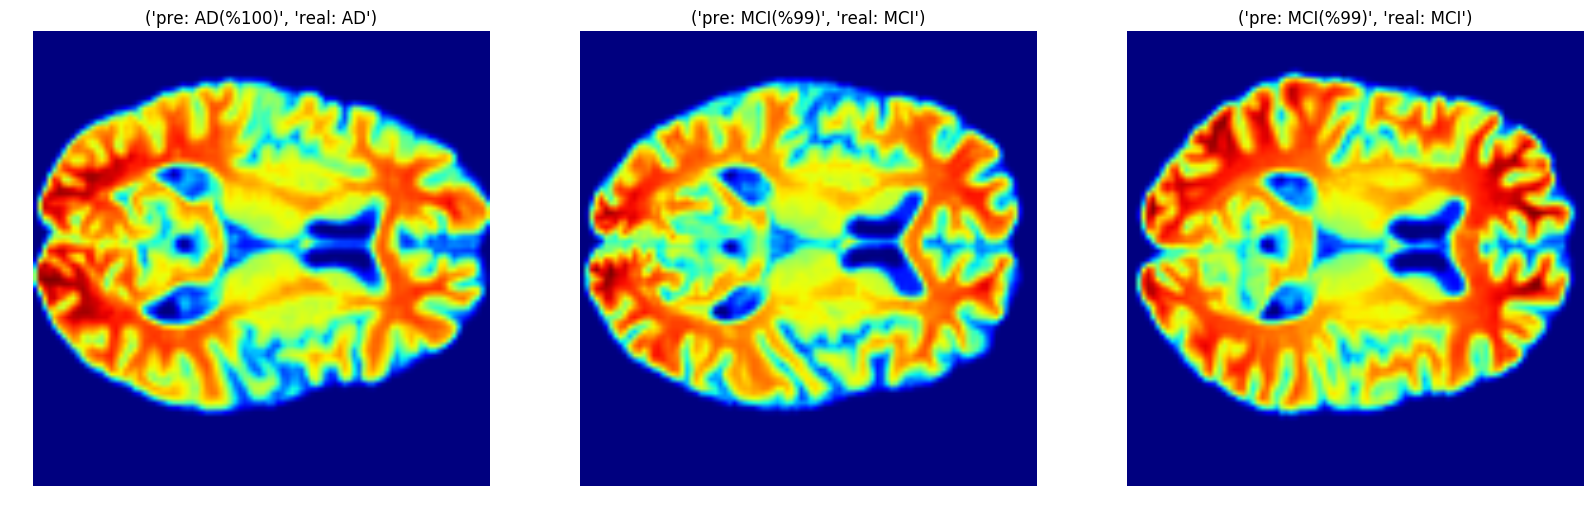

In [38]:
from PIL import Image
import os
import sys
%matplotlib inline

numCol = 3

plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=1, ncols=numCol)

im_samples = []
print(testPredictions.shape)    
for i, j in enumerate(np.sort(np.random.randint(0, testPredictions.shape[0], size=numCol))):
    im = np.asarray(test_dataset[j,:,:,0])
    pre1Alz = np.str(int(testPredictions[j,0]*100))
    pre2Alz = np.str(int(testPredictions[j,1]*100))
    pre3Alz = np.str(int(testPredictions[j,2]*100))
    lbl = np.argmax(test_labels[j])
    if lbl == 0:
        tgtAlz = 'Normal'
    elif lbl == 1:
        tgtAlz = 'MCI'
    elif lbl == 2 :
        tgtAlz = 'AD'
    lbl = np.argmax(testPredictions[j])
    if lbl == 0:
        preAlz = 'Normal(%'+pre1Alz+')'
    elif lbl == 1:
        preAlz = 'MCI(%'+pre2Alz+')'
    elif lbl == 2 :
        preAlz = 'AD(%'+pre3Alz+')'
    #print(pre1Alz,pre2Alz,pre3Alz,tgtAlz)
    im_samples.extend([j])
    ax[i].axis('off')
    ax[i].set_title(('pre: '+preAlz,'real: '+tgtAlz), loc='center')
    ax[i].imshow(im)